In [1]:
from math import log 

def calc_shannon_ent(dataset):
    """计算香农熵"""
    num_entries = len(dataset)
    label_counts = {}
    for feat_vec in dataset:
        current_label = feat_vec[-1]
        if current_label not in label_counts.keys():    # 为了所有可能的分类创建字典
            label_counts[current_label] = 0
        label_counts[current_label] += 1
    shannon_ent = 0.0 
    for key in label_counts:
        prob = float(label_counts[key]) / num_entries   # 计算选择此类的概率
        shannon_ent -= prob * log(prob, 2)  # 以2为底求对数
    return shannon_ent

In [2]:
def create_dataset():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    # 这里的label代表的是dataset里面前两列特征的实际含义
    # 避免和别的label搞混淆
    return dataSet, labels

In [3]:
my_dat, labels = create_dataset()

In [4]:
my_dat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [5]:
calc_shannon_ent(my_dat)

0.9709505944546686

In [6]:
my_dat[0][-1] = 'maybe'
my_dat

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [7]:
calc_shannon_ent(my_dat)

1.3709505944546687

In [8]:
def split_dataset(dataset, axis, value):
    """按照指定特征划分数据集"""
    ret_dataset = []
    for feat_vec in dataset:
        if feat_vec[axis] == value:
            reduced_feat_vec = feat_vec[:axis]
            reduced_feat_vec.extend(feat_vec[axis+1:])
            ret_dataset.append(reduced_feat_vec)    # 抽取符合要求的数据
    return ret_dataset

In [9]:
my_dat, labels = create_dataset()
my_dat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [10]:
split_dataset(my_dat, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [11]:
split_dataset(my_dat, 0, 0)

[[1, 'no'], [1, 'no']]

In [12]:
def choose_best_feature_to_split(dataset):
    """选择最好的数据划分方式"""
    num_features = len(dataset[0]) - 1
    base_entroy = calc_shannon_ent(dataset)
    best_info_gain = 0.0; best_feature = -1 # 初始化原数据集的香农熵
    for i in range(num_features):
        feat_list = [example[i] for example in dataset]
        unique_vals = set(feat_list)    # 创建唯一的分类标签set
        new_entroy = 0.0 
        for value in unique_vals:
            sub_dataset = split_dataset(dataset, i, value)
            prob = len(sub_dataset) / float(len(dataset))
            new_entroy += prob * calc_shannon_ent(sub_dataset)  # 计算每种划分方式的信息熵
        info_gain = base_entroy - new_entroy
        if (info_gain > best_info_gain):
            best_info_gain = info_gain
            best_feature = i    # 计算最多信息增益下的划分特征
    return best_feature

In [13]:
my_dat, labels = create_dataset()
my_dat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [14]:
choose_best_feature_to_split(my_dat)

0

In [15]:
import operator

def majority_cnt(class_list):
    """返回数量最多的类"""
    class_count = {}
    for vote in class_list:
        if vote not in class_count.keys():
            class_count[vote] = 0
        class_count[vote] += 1
    
    sorted_class_count = sorted(class_count.items(), key=lambda x: x[1], reverse=True)
    return sorted_class_count[0][0]

In [16]:
def create_tree(dataset, labels):
    """创建树"""
    class_list = [example[-1] for example in dataset]
    if class_list.count(class_list[0]) == len(class_list):  # 类别完全相同，停止划分
        return class_list[0]
    if len(dataset[0]) == 1:
        return majority_cnt(class_list)     # 遍历完所有特征时返回出现次数最多的
    best_feat = choose_best_feature_to_split(dataset)
    best_feat_label = labels[best_feat]
    my_tree = {best_feat_label: {}}
    del(labels[best_feat])
    feat_vals = [example[best_feat] for example in dataset]
    unique_vals = set(feat_vals)
    for value in unique_vals:
        sub_labels = labels[:]
        my_tree[best_feat_label][value] =\
             create_tree(split_dataset(dataset, best_feat, value), sub_labels)
    return my_tree

In [17]:
my_dat, labels = create_dataset()
my_tree = create_tree(my_dat, labels)
my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [19]:
# 使用文本注释绘制树
import matplotlib.pyplot as plt 

decision_node = dict(boxstyle='sawtooth', fc='0.8')
leaf_node = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')

def plot_node(node_text, center_pt, parent_pt, node_type):
    create_plot.ax1.annotate(node_text, xy=parent_pt,  xycoords='axes fraction',
             xytext=center_pt, textcoords='axes fraction',
             va="center", ha="center", bbox=node_type, arrowprops=arrow_args)

def create_plot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    create_plot.ax1 = plt.subplot(111, frameon= False)
    plot_node('decision node', (0.5, 0.1), (0.1, 0.6), decision_node)
    plot_node('leaf node', (0.8, 0.1), (0.3, 0.8), leaf_node)
    plt.show()        

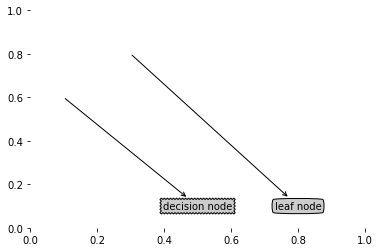

In [20]:
create_plot()

In [24]:
# 开始构造注解树

def get_num_leafs(my_tree):
    """获得叶节点数目"""
    num_leafs = 0 
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]) == dict:
            num_leafs += get_num_leafs(second_dict[key])
        else:
            num_leafs += 1
    return num_leafs

def get_tree_depth(my_tree):
    """获取树的层数"""
    max_depth = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]) == dict:
            this_depth = 1 + get_tree_depth(second_dict[key])
        else:
            this_depth = 1
        if this_depth > max_depth: 
            max_depth = this_depth
    return max_depth

In [27]:
def retrieve_tree(i):
    """预先构造好的两个树"""
    list_of_tree =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return list_of_tree[i]

In [29]:
retrieve_tree(1)

{'no surfacing': {0: 'no',
  1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}

In [30]:
my_tree = retrieve_tree(0)
get_num_leafs(my_tree)

3

In [31]:
get_tree_depth(my_tree)

2

In [45]:
def plot_mid_text(cntr_pt, parent_pt, txt_string):
    """在父子节点之间填充文本信息"""
    x_mid = (parent_pt[0] - cntr_pt[0]) / 2.0 + cntr_pt[0]
    y_mid = (parent_pt[1] - cntr_pt[1]) / 2.0 + cntr_pt[1]
    create_plot.ax1.text(x_mid, y_mid, txt_string)


def plot_tree(my_tree, parent_pt, node_txt):
    num_leafs = get_num_leafs(my_tree)
    depth = get_tree_depth(my_tree) # 计算宽和高
    first_str = list(my_tree.keys())[0]
    cntr_pt = (plot_tree.xoff + (1.0 + float(num_leafs)) / 2.0 / plot_tree.totalw,
                plot_tree.yoff)
    plot_mid_text(cntr_pt, parent_pt, node_txt) # 标记子叶节点属性
    plot_node(first_str, cntr_pt, parent_pt, decision_node)
    second_dict = my_tree[first_str]
    plot_tree.yoff = plot_tree.yoff - 1.0 / plot_tree.totald    # 减少y偏移
    for key in second_dict.keys():
        if type(second_dict[key]) == dict:
            plot_tree(second_dict[key], cntr_pt, str(key))
        else:
            plot_tree.xoff = plot_tree.xoff + 1.0 / plot_tree.totalw
            plot_node(second_dict[key], (plot_tree.xoff, plot_tree.yoff),
                      cntr_pt, leaf_node)
            plot_mid_text((plot_tree.xoff, plot_tree.yoff), cntr_pt, str(key))
    plot_tree.yoff = plot_tree.yoff + 1.0/plot_tree.totald


def create_plot(in_tree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon = False, **axprops)
    plot_tree.totalw = float(get_num_leafs(in_tree))
    plot_tree.totald = float(get_tree_depth(in_tree))
    plot_tree.xoff = -0.5 / plot_tree.totalw
    plot_tree.yoff = 1.0
    plot_tree(in_tree, (0.5, 1.0), '')
    plt.show()

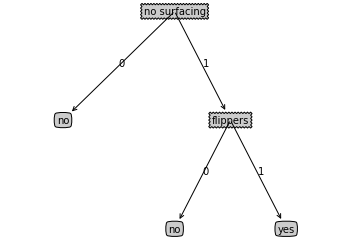

In [46]:
my_tree = retrieve_tree(0)
create_plot(my_tree)

In [47]:
my_tree['no surfacing'][3] = 'maybe'
my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}

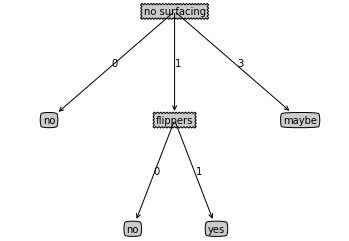

In [48]:
create_plot(my_tree)

In [49]:
def classify(input_tree, feat_labels, test_vec):
    """使用决策树的分类函数"""
    first_str = list(input_tree.keys())[0]
    second_dict = input_tree[first_str]
    feat_index = feat_labels.index(first_str)
    for key in second_dict.keys():
        if test_vec[feat_index] == key:
            if type(second_dict[key]) == dict:
                class_label = classify(second_dict[key], feat_labels, test_vec)
            else:
                class_label = second_dict[key]
    return class_label

In [50]:
my_dat, labels = create_dataset()
labels

['no surfacing', 'flippers']

In [52]:
my_tree = retrieve_tree(0)
my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [53]:
classify(my_tree, labels, [1,0])

'no'

In [54]:
classify(my_tree, labels, [1,1])

'yes'

In [67]:
# 使用pickle模块存储决策树

def store_tree(input_tree, filename):
    import pickle
    with open(filename, 'wb') as fw:
        pickle.dump(input_tree, fw)

def grab_tree(filename):
    import pickle
    with open(filename, 'rb') as fr:
        tree = pickle.load(fr)
    return tree

my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [68]:
store_tree(my_tree, 'classifierStorage.txt')

In [69]:
grab_tree('classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 隐形眼镜决策树

In [70]:
with open('lenses.txt') as fr:
    lenses = [inst.strip().split('\t') for inst in fr.readlines()]
    lenses_labels = ['age', 'prescript', 'astigmatic', 'tearRate']
    lenses_tree = create_tree(lenses, lenses_labels)
lenses_tree

{'tearRate': {'reduced': 'no lenses',
  'normal': {'astigmatic': {'no': {'age': {'young': 'soft',
      'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}}},
    'yes': {'prescript': {'hyper': {'age': {'young': 'hard',
        'pre': 'no lenses',
        'presbyopic': 'no lenses'}},
      'myope': 'hard'}}}}}}

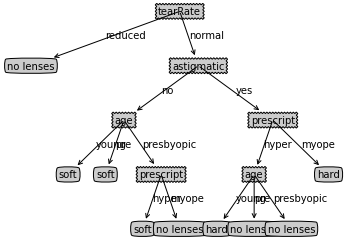

In [71]:
create_plot(lenses_tree)